# NYC Taxi Wait Time Estimation

### Matt Wong

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import shapely

## The Data
Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The full data set takes a long time to download directly, so we've placed a simple random sample of the data into `taxi.db`, a SQLite database. You can view the code used to generate this sample in the `taxi_sample.ipynb` file included with this project (not required).

Columns of the `taxi` table in `taxi.db` include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

Your goal will be to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

## Data Selection and Cleaning

Our database is actually quite large (Every taxi trip in NYC in January 2016!) so for the purposes of this project we're going to work with a subset of the data. 

In [2]:
import sqlite3
conn = sqlite3.connect('taxi.db')
nyc_lon_bounds = [-74.03, -73.75]
nyc_lat_bounds = [40.6, 40.88]
command ="""
SELECT * FROM taxi
WHERE pickup_lon BETWEEN -74.03 AND -73.75 
AND pickup_lat BETWEEN 40.6 AND 40.88 
AND dropoff_lon BETWEEN -74.03 AND -73.75
AND dropoff_lat BETWEEN 40.6 AND 40.88
"""
all_taxi = pd.read_sql_query(command,conn)
all_taxi.head()

pickup_datetime     dropoff_datetime  pickup_lon  pickup_lat  \
0  2016-01-30 22:47:32  2016-01-30 23:03:53  -73.988251   40.743542   
1  2016-01-04 04:30:48  2016-01-04 04:36:08  -73.995888   40.760010   
2  2016-01-07 21:52:24  2016-01-07 21:57:23  -73.990440   40.730469   
3  2016-01-01 04:13:41  2016-01-01 04:19:24  -73.944725   40.714539   
4  2016-01-08 18:46:10  2016-01-08 18:54:00  -74.004494   40.706989   

   dropoff_lon  dropoff_lat  passengers  distance  duration  
0   -74.015251    40.709808           1      3.99       981  
1   -73.975388    40.782200           1      2.03       320  
2   -73.985542    40.738510           1      0.70       299  
3   -73.955421    40.719173           1      0.80       343  
4   -74.010155    40.716751           5      0.97       470

A scatter plot of pickup locations shows that most of them are on the island of Manhattan. The empty white rectangle is Central Park; cars are not allowed there.

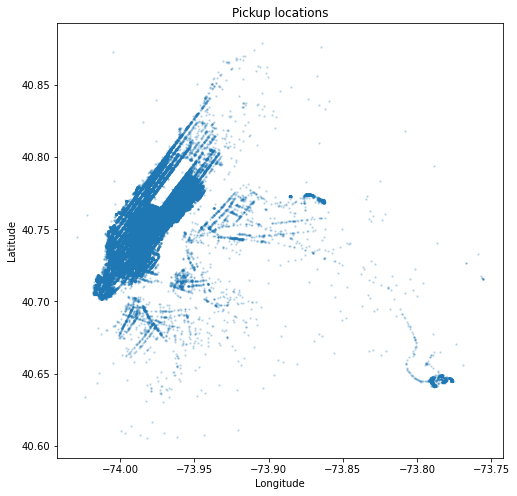

In [3]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

The two small blobs outside of Manhattan with very high concentrations of taxi pick-ups are airports.

We need to do some data cleaning! There are rows with negative passenger count or zero distance. These don't make sense so let's get rid of them.

In [4]:
positive_distance = all_taxi[all_taxi["distance"]>0]
good_duration = positive_distance[positive_distance["duration"].between(60,3600, inclusive=True)]
good_speed = good_duration[(good_duration["distance"]/(good_duration["duration"]/3600)) <= 100]


clean_taxi = good_speed
clean_taxi.head()

pickup_datetime     dropoff_datetime  pickup_lon  pickup_lat  \
0  2016-01-30 22:47:32  2016-01-30 23:03:53  -73.988251   40.743542   
1  2016-01-04 04:30:48  2016-01-04 04:36:08  -73.995888   40.760010   
2  2016-01-07 21:52:24  2016-01-07 21:57:23  -73.990440   40.730469   
3  2016-01-01 04:13:41  2016-01-01 04:19:24  -73.944725   40.714539   
4  2016-01-08 18:46:10  2016-01-08 18:54:00  -74.004494   40.706989   

   dropoff_lon  dropoff_lat  passengers  distance  duration  
0   -74.015251    40.709808           1      3.99       981  
1   -73.975388    40.782200           1      2.03       320  
2   -73.985542    40.738510           1      0.70       299  
3   -73.955421    40.719173           1      0.80       343  
4   -74.010155    40.716751           5      0.97       470

Let's see which rows are found in Manhattan. Using the Shapely package we should be able to select points from inside the polygon Mahattan's borders create. We have a dataset of points that outline the Borough's borders (haha tongue twister!)

In [6]:
from shapely.geometry import Point
from shapely.geometry import Polygon
polygon = pd.read_csv('manhattan.csv')
manhattan = []
for x,row in polygon.iterrows():
    manhattan.append((row.lat,row.lon))
area = Polygon(manhattan)
def in_manhattan(row):
    """Whether a longitude-latitude (x, y) pair is in the Manhattan polygon."""
    start_point = Point(row["pickup_lat"],row["pickup_lon"])
    end_point = Point(row["dropoff_lat"],row["dropoff_lon"])
    return start_point.within(area) & end_point.within(area)
    
manhattan_taxi = clean_taxi[clean_taxi.apply(in_manhattan,axis=1)]

In [ ]:
#manhattan_taxi = pd.read_csv('manhattan_taxi.csv')

A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island. 

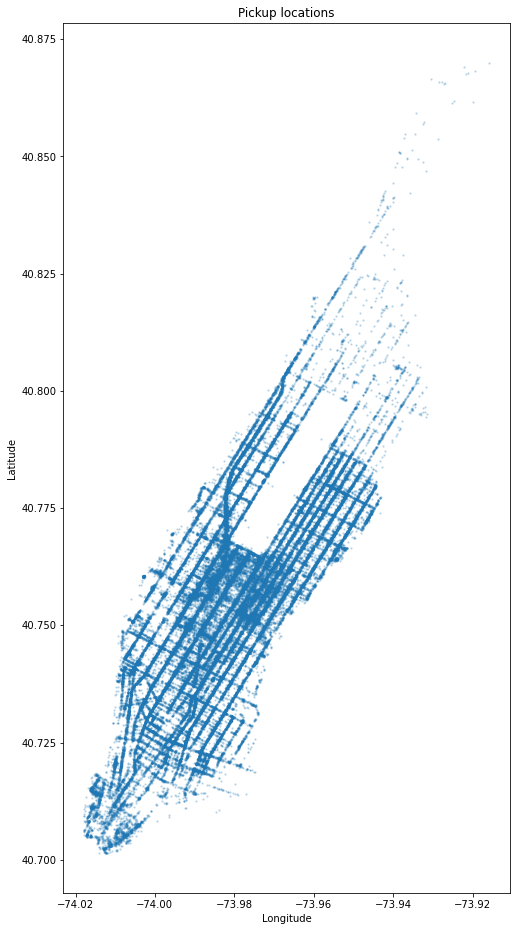

In [7]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

Here's a summary of the data we're working with so far

In [9]:
print(f"""
      all_taxi contains {len(all_taxi)} rows. By cleaning this table of weird outliers,
      we're left with clean_taxi which contains {len(clean_taxi)} rows and retains {np.round(100*(len(clean_taxi))/len(all_taxi),3)} percent of the original data.
      Finally, manhattan_taxi has {len(manhattan_taxi)} rows which and retains {np.round(100*len(manhattan_taxi)/len(all_taxi),3)} percent of the original data.
""")


      all_taxi contains 97692 rows. By cleaning this table of weird outliers,
      we're left with clean_taxi which contains 96445 rows and retains 98.724 percent of the original data.
      Finally, manhattan_taxi has 82800 rows which and retains 84.756 percent of the original data.



## Exploratory Data Analysis
Let's do some EDA to get familiar with the data.

First let's get a date value for each ride

In [14]:
import re,datetime
def extract_date(string):
    return datetime.datetime.strptime(string[0:10],"%Y-%m-%d").date()
manhattan_taxi["date"] = manhattan_taxi["pickup_datetime"].apply(extract_date)

<ipython-input-14-a931b1592a67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manhattan_taxi["date"] = manhattan_taxi["pickup_datetime"].apply(extract_date)


In [15]:
manhattan_taxi.head()

pickup_datetime     dropoff_datetime  pickup_lon  pickup_lat  \
0  2016-01-30 22:47:32  2016-01-30 23:03:53  -73.988251   40.743542   
1  2016-01-04 04:30:48  2016-01-04 04:36:08  -73.995888   40.760010   
2  2016-01-07 21:52:24  2016-01-07 21:57:23  -73.990440   40.730469   
4  2016-01-08 18:46:10  2016-01-08 18:54:00  -74.004494   40.706989   
5  2016-01-02 12:39:57  2016-01-02 12:53:29  -73.958214   40.760525   

   dropoff_lon  dropoff_lat  passengers  distance  duration        date  
0   -74.015251    40.709808           1      3.99       981  2016-01-30  
1   -73.975388    40.782200           1      2.03       320  2016-01-04  
2   -73.985542    40.738510           1      0.70       299  2016-01-07  
4   -74.010155    40.716751           5      0.97       470  2016-01-08  
5   -73.983360    40.760406           1      1.70       812  2016-01-02

There was a blizzard in January 2016. Let's visualize so we can see how it affected ride volume.

pickup_datetime  dropoff_datetime  pickup_lon  pickup_lat  \
date                                                                    
2016-01-01             2337              2337        2337        2337   
2016-01-02             2411              2411        2411        2411   
2016-01-03             2177              2177        2177        2177   
2016-01-04             2368              2368        2368        2368   
2016-01-05             2630              2630        2630        2630   

            dropoff_lon  dropoff_lat  passengers  distance  duration  
date                                                                  
2016-01-01         2337         2337        2337      2337      2337  
2016-01-02         2411         2411        2411      2411      2411  
2016-01-03         2177         2177        2177      2177      2177  
2016-01-04         2368         2368        2368      2368      2368  
2016-01-05         2630         2630        2630      2630      2630

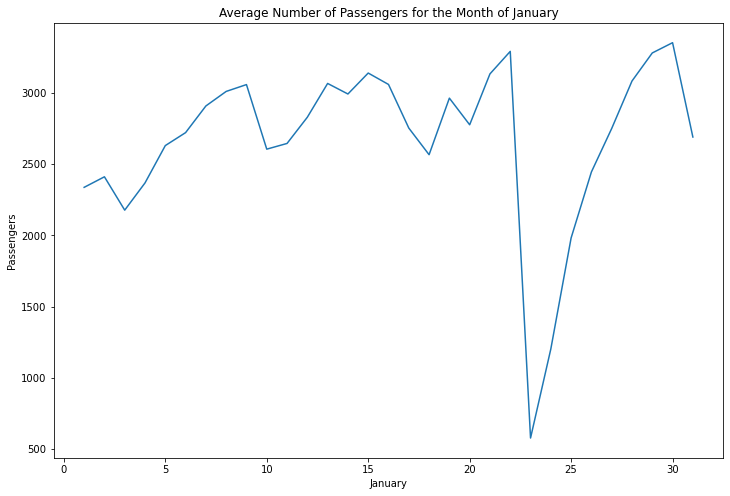

In [12]:
num_by_date = manhattan_taxi.groupby("date").count()
plt.figure(figsize=(12,8))
plt.plot(np.arange(1,32),"distance",data=num_by_date)
plt.xlabel("January")
plt.ylabel("Passengers")
plt.title("Average Number of Passengers for the Month of January")
num_by_date.head()

Feature Engineering

In this part, you'll create a design matrix (i.e., feature matrix) for your linear regression model. You decide to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

You will ensure that the process of transforming observations into a design matrix is expressed as a Python function called `design_matrix`, so that it's easy to make predictions for different samples in later parts of the project.

Because you are going to look at the data in detail in order to define features, it's best to split the data into training and test sets now, then only inspect the training set.

## Feature Engineering

I'm planning on using start location, end location, trip distance, time of day, and day of week to predict trip duration. Let's get started

In [16]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


### Question 3a

Create a box plot that compares the distributions of taxi trip durations for each day **using `train` only**. Individual dates shoud appear on the horizontal axis, and duration values should appear on the vertical axis. Your plot should look like this:

![](images/3a_duration_by_date.png)


<!--
BEGIN QUESTION
name: q3a
points: 2
manual: True
format: image
-->
<!-- EXPORT TO PDF -->

Let's see how the date affects trip duration

Text(0.5, 1.0, 'January Trip Durations')

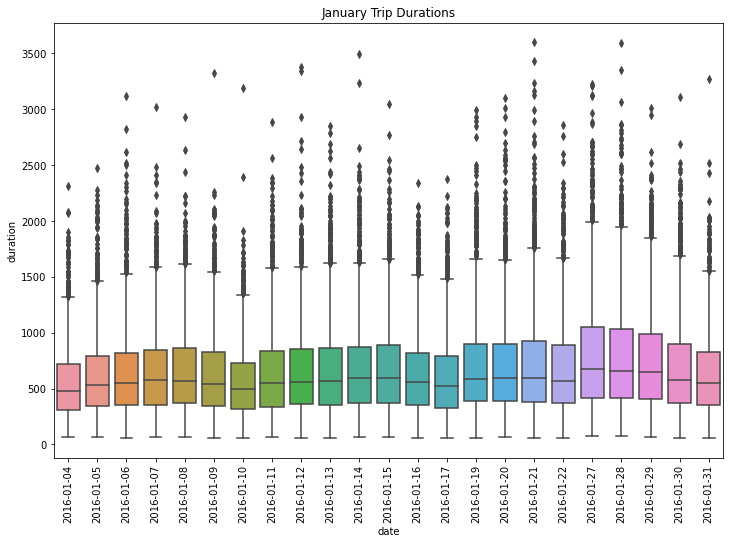

In [18]:
plt.figure(figsize=(12,8))
sns.boxplot(x="date",y="duration",data=train.sort_values("date"))
plt.xticks(rotation='vertical');
plt.title("January Trip Durations")

### It seems that weekdays have a longer ride duration than the weekends. This may suggest that people drive out to the airport more often during the week than on the weekends or that people use taxi's during the week more often in general.

### Let's add some more columns

In [20]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)
train.iloc[30,:] # An example row

pickup_datetime     2016-01-05 21:06:13
dropoff_datetime    2016-01-05 21:15:31
pickup_lon                     -73.9795
pickup_lat                      40.7672
dropoff_lon                    -73.9602
dropoff_lat                     40.7756
passengers                            1
distance                           2.15
duration                            558
date                         2016-01-05
hour                                 21
day                                   1
weekend                               0
period                                3
speed                            13.871
Name: 31861, dtype: object

### Speed affects trip duration, so let's see how speeds change given time of day

C:\Users\Bear\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Bear\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Bear\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

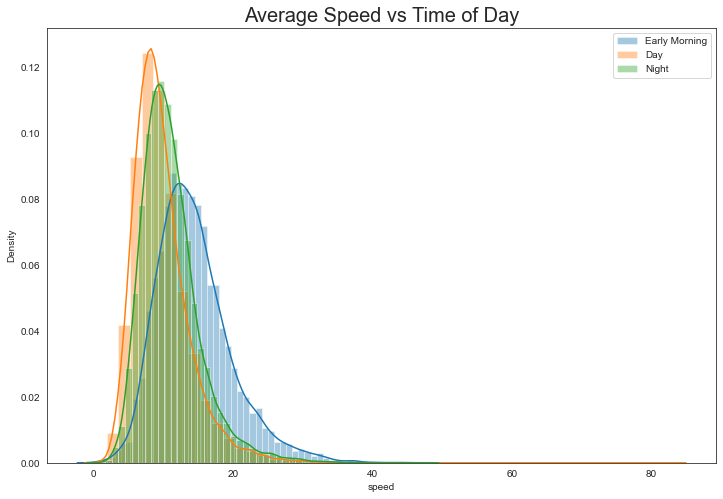

In [25]:
sns.set_style("white")
plt.figure(figsize=(12,8))
avg_speed = train["distance"]/train["speed"]
times = [[0,6,"Early Morning"],[6,18,"Day"],[18,24,"Night"]]
for x in times:
    sns.distplot(train[train["hour"].between(x[0],x[1],inclusive=True)]["speed"],label=x[2])
plt.title("Average Speed vs Time of Day",size=20)
plt.legend();

It looks like the time of day is definitely associated with the average speed of a taxi ride.

Let's do PCA to find the first principal component for pick up location. They should roughly correspond to the Upper, Lower, and Midtown regions in Manhattan. 

In [26]:
# Find the first principle component
D = train[["pickup_lat","pickup_lon"]]
pca_n = len(D)
pca_means = np.mean(D)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[["pickup_lat","pickup_lon"]]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = X@vt.T[:,0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

In [27]:
train[train["region"]==0]

pickup_datetime     dropoff_datetime  pickup_lon  pickup_lat  \
10957  2016-01-04 20:34:21  2016-01-04 20:42:33  -74.006554   40.732922   
23611  2016-01-22 21:37:35  2016-01-22 21:38:37  -73.997116   40.724838   
79674  2016-01-30 23:59:45  2016-01-31 00:23:44  -73.988640   40.717712   
78992  2016-01-30 00:22:55  2016-01-30 00:27:29  -74.014717   40.713631   
49960  2016-01-29 17:12:50  2016-01-29 17:26:57  -73.995270   40.750477   
...                    ...                  ...         ...         ...   
86089  2016-01-16 02:14:14  2016-01-16 02:38:53  -73.987411   40.721142   
94526  2016-01-06 21:58:04  2016-01-06 22:10:54  -73.988388   40.734512   
87740  2016-01-06 17:54:58  2016-01-06 18:17:41  -74.011810   40.702301   
1245   2016-01-04 05:46:00  2016-01-04 05:52:29  -73.984055   40.725250   
23043  2016-01-27 06:49:31  2016-01-27 06:57:36  -73.983162   40.738796   

       dropoff_lon  dropoff_lat  passengers  distance  duration        date  \
10957   -74.001175    40.751366           1      1.60       492  2016-01-04   
23611   -73.994217    40.726467           1      0.20        62  2016-01-22   
79674   -73.991768    40.749195           1      2.90      1439  2016-01-30   
78992   -74.009247    40.713051           2      0.43       274  2016-01-30   
49960   -73.986710    40.740505           1      1.39       847  2016-01-29   
...            ...          ...         ...       ...       ...         ...   
86089   -73.953598    40.788139           1      6.90      1479  2016-01-16   
94526   -73.971970    40.750561           1      2.20       770  2016-01-06   
87740   -73.948265    40.784214           1      8.10      1363  2016-01-06   
1245    -74.001221    40.731049           1      1.00       389  2016-01-04   
23043   -73.989098    40.748173           1      0.90       485  2016-01-27   

       hour  day  weekend  period      speed region  
10957    20    0        0       3  11.707317      0  
23611    21    4        0       3  11.612903      0  
79674    23    5        1       3   7.255038      0  
78992     0    5        1       1   5.649635      0  
49960    17    4        0       2   5.907910      0  
...     ...  ...      ...     ...        ...    ...  
86089     2    5        1       1  16.795132      0  
94526    21    2        0       3  10.285714      0  
87740    17    2        0       2  21.393984      0  
1245      5    0        0       1   9.254499      0  
23043     6    2        0       2   6.680412      0  

[17894 rows x 16 columns]

Let's see how PCA divided the trips into three groups. These regions do roughly correspond to Lower Manhattan (below 14th street), Midtown Manhattan (between 14th and the park), and Upper Manhattan (bordering Central Park). No prior knowledge of New York geography was required!

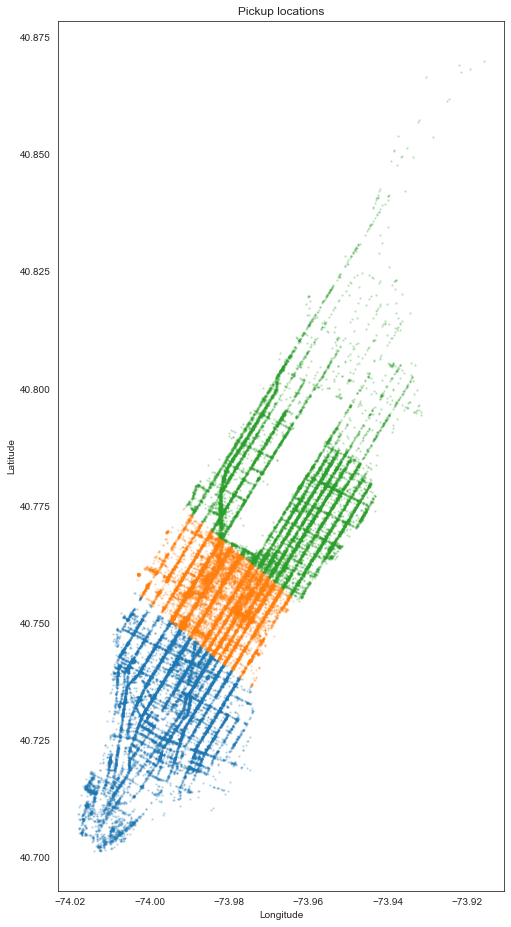

In [28]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

### Using our constructed regions, let's see how speed (and hopefully trip duration) differs between them. 

C:\Users\Bear\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Bear\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Bear\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot

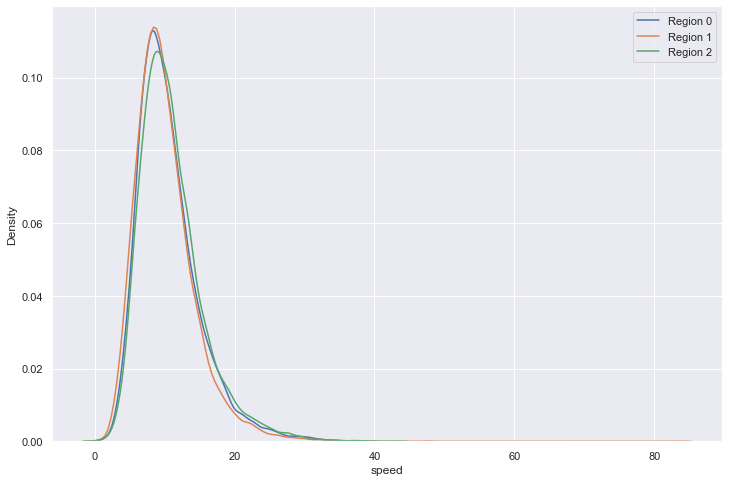

In [30]:
sns.set()
plt.figure(figsize=(12,8))
for i in np.unique(train["region"]):
    sns.distplot(train[train["region"]==i]["speed"],label="Region " + str(i),hist=False)
plt.legend()
plt.show()

Finally, we create a design matrix that includes many of these features. Quantitative features are converted to standard units, while categorical features are converted to dummy variables using one-hot encoding. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is not included because it was computed from the `duration`; it's impossible to know the speed without knowing the duration, given that you know the distance.

In [31]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

design_matrix(train).iloc[0,:]  

pickup_lon    -0.805821
pickup_lat    -0.171761
dropoff_lon    0.954062
dropoff_lat    0.624203
distance       0.626326
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         0.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        1.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          1.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 16548, dtype: float64

## Model Selection

Let's select a regression model to predict the duration of a taxi ride.

In [34]:
y_train = train["duration"]
X_train = design_matrix(train)

First let's examine a constant linear model (trivial solution)

In [35]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))
constant_rmse = rmse(test["duration"]-train["duration"].mean())
constant_rmse

399.1437572352677

Yeesh. We can do better.

Let's regress using distance as a covariate

In [36]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train["distance"].values.reshape(-1,1),y_train)
y_pred = model.predict(design_matrix(test)["distance"].values.reshape(-1,1))
simple_rmse = rmse(y_pred-test["duration"])
simple_rmse

276.7841105000337

It's an improvement, but we can still do better. Let's see how using our design matrix from earlier does

In [37]:
model = LinearRegression()
model.fit(X_train,y_train)
linear_rmse = rmse(test["duration"]-model.predict(design_matrix(test)))
linear_rmse

255.19146631882785

### Question 4d

For each possible value of `period`, fit an unregularized linear regression model to the subset of the training set in that `period`.  Assign `period_rmse` to the root mean squared error on the test set for a model that first chooses linear regression parameters based on the observed period of the taxi ride, then predicts the duration using those parameters. Again, fit to the training set and use the `design_matrix` function for features.

<!--
BEGIN QUESTION
name: q4d
points: 2
-->

Let's do a simple decision tree (depth 1) by iterating over all values of `period`

In [38]:
model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    model.fit(design_matrix(train)[train["period"]==v],y_train[train["period"]==v])
    pred = model.predict(design_matrix(test)[test["period"]==v])
    errors.extend(test[test["period"]==v]["duration"]-pred)
period_rmse = rmse(np.array(errors))
period_rmse

246.62868831165176

The period regression model creates a relationship between the time of day and the hours which increases variance with a new feature but also decreases bias. 

### Average Speed Model

Since we know the distance of each trip, we can predict duration by multiplying average speed times distance. 

In [40]:
def convert(mph,distance):
    return distance/mph*3600
model = LinearRegression()
model.fit(design_matrix(train),train["speed"])
y_speeds = model.predict(design_matrix(test))
speed_rmse = rmse(convert(y_speeds,test["distance"])-test["duration"])
speed_rmse

243.0179836851497

Using average speed to predict duration is a bit more accurate since it takes into account traffic and stoplight patterns

### Question 4g

Finally, complete the function `tree_regression_errors` (and helper function `speed_error`) that combines the ideas from the two previous models and generalizes to multiple categorical variables.

The `tree_regression_errors` should:
- Find a different linear regression model for each possible combination of the variables in `choices`;
- Fit to the specified `outcome` (on train) and predict that `outcome` (on test) for each combination (`outcome` will be `'duration'` or `'speed'`);
- Use the specified `error_fn` (either `duration_error` or `speed_error`) to compute the error in predicted duration using the predicted outcome;
- Aggregate those errors over the whole test set and return them.

You should find that including each of `period`, `region`, and `weekend` improves prediction accuracy, and that predicting speed rather than duration leads to more accurate duration predictions.

<!--
BEGIN QUESTION
name: q4g
points: 4
-->

### Time for the biggie. Let's do a tree regression that fits a model for a series of choices

In [41]:
model = LinearRegression()
choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    return convert(predictions,observations["distance"]) - observations["duration"]

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    errors = []
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train[v_train[c]==v]
            v_test = v_test[v_test[c]==v]
        model.fit(design_matrix(v_train), v_train[outcome])
        pred = model.predict(design_matrix(v_test))
        error = error_fn(pred,v_test)
        errors.extend(error)
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)
tree_rmse = rmse(np.array(errors))
tree_speed_rmse = rmse(np.array(errors_via_speed))
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 240.3395219270353 
Speed: 226.90793945018314


### Here's a summary of the results:

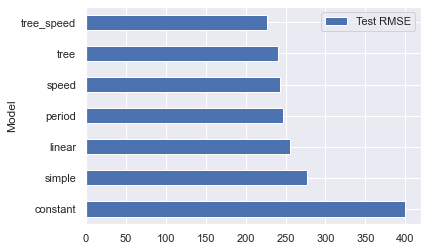

In [42]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');